<a href="https://colab.research.google.com/github/rohankannan/MotorMarket/blob/main/preliminary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$x \to$  Model  $\to \hat y$

$\hat y \to $ Strategy $\to $ Market Orders

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

import torch
import torch.nn as nn
import torch.optim as optim

import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
#RESEARCH PARAMS#
sym = "NVDA"       # trading symbol
data_window = "1y"  # 6 months roughly
time_interval = '1d'  # time horizon of time series
max_lags = 4          # autoregressive lags max
forecast_horizon = 1  # 1 step forward (1d default) for forecasting

In [ ]:
ts = yf.download(sym, period=data_window)
ts = ts.drop('Volume',axis=1)
ts = ts.reset_index()
ts

/tmp/ipython-input-2679563203.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ts = yf.download(sym, period=data_window)
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open
Ticker,,NVDA,NVDA,NVDA,NVDA
0,2024-11-04,136.011002,138.920171,135.531143,137.170673
1,2024-11-05,139.869888,140.329748,137.290626,137.410587
2,2024-11-06,145.568253,146.448005,141.919305,142.919018
3,2024-11-07,148.837341,148.887315,146.128111,146.348049
4,2024-11-08,147.587677,149.727063,146.218059,148.727350
...,...,...,...,...,...
245,2025-10-28,201.029999,203.149994,191.910004,193.050003
246,2025-10-29,207.039993,212.190002,204.779999,207.979996
247,2025-10-30,202.889999,206.160004,201.410004,205.149994


<Axes: ylabel='close_log_return'>

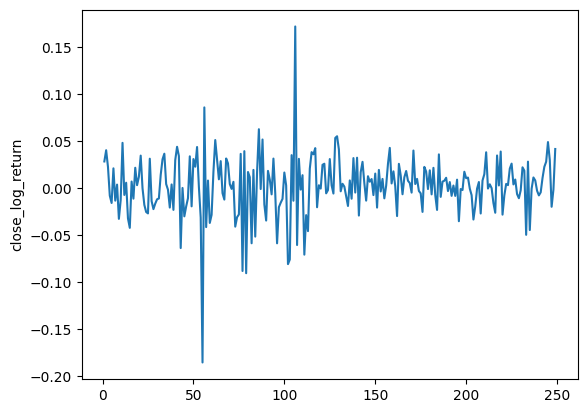

In [ ]:
# This cell only works properly when you click Run All at the top
target = "close_log_return"
ts[target] = np.log(ts['Close'] / ts['Close'].shift(forecast_horizon))


In [ ]:
for i in range(1, max_lags + 1):
    ts[f"{target}_lag_{i}"] = ts[target].shift(forecast_horizon * i)
ts.dropna(inplace=True)


In [ ]:
# yhat = weight * x + bias
class LinearModel(nn.Module):
  def __init__(self, input_features):
    super(LinearModel, self).__init__()
    self.linear = nn.Linear(input_features, 1)

  def forward(self, x):
    return self.linear(x)

In [ ]:
def train_features(features):
  target = 'close_log_return'
  test_size = 0.25
  train_size = 1 - test_size

  split_index = int(len(ts) * train_size)
  train_data = ts[:split_index]
  test_data = ts[split_index:]

  X_train = torch.tensor(train_data[features].values, dtype=torch.float32)
  X_test = torch.tensor(test_data[features].values, dtype=torch.float32)
  y_train = torch.tensor(train_data[target].values, dtype=torch.float32)
  y_test = torch.tensor(test_data[target].values, dtype=torch.float32)

  y_train = y_train.reshape(-1,1)
  y_test = y_test.reshape(-1,1)

  num_epochs = 1000 * 5
  learning_rate = 0.0005

  model = LinearModel(len(features))
  criterion = nn.MSELoss() # experiment with diff loss functions
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  print("Training model...")
  for epoch in range(num_epochs):
    # forward
    y_hat = model(X_train)
    loss = criterion(y_hat, y_train)
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss = loss.item()

    if (epoch + 1) % 500 == 0:
      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.5f}")

  print("Training finished!")
  print("Learned parameters")
  for name, param in model.named_parameters():
    if param.requires_grad:
      print(name)
      print(param.data.numpy())

  # Evaluation
  model.eval()
  with torch.no_grad():
    y_hat = model(X_test)
    test_loss = criterion(y_hat, y_test)
    print("Big deviation between the two is a red flag!")
    print(f"Test Loss: {test_loss.item():.5f}, Train Loss: {train_loss:.5f}")

  # Test market performance
  trade_results = pd.DataFrame({
          'y_hat': y_hat.numpy().flatten(),
          'y': y_test.numpy().flatten()
      })
  trade_results["is_won"] = trade_results['y_hat'].apply(lambda x: True if x > 0 else False)
  trade_results["signal"] = trade_results['y_hat'].apply(lambda x: 1 if x > 0 else -1)
  trade_results["trade_log_return"] = trade_results['signal'] * trade_results['y']
  trade_results["equity_curve"] = trade_results["trade_log_return"].cumsum()

  return trade_results


In [ ]:

benchmarks = []

for i in range(1, max_lags + 1):
    trade_results = train_features([f"{target}_lag_{i}"])

    trade_results['drawdown_log'] = trade_results['equity_curve'] - trade_results['equity_curve'].cummax()
    max_drawdown_log = (trade_results['drawdown_log'].min())

    drawdown_pct = (np.exp(max_drawdown_log) - 1)

    win_rate = (trade_results['is_won'].mean())

    avg_win = (trade_results[trade_results['is_won'] == True]['trade_log_return'].mean())
    avg_loss = (trade_results[trade_results['is_won'] == False]['trade_log_return'].mean())

    ev = (win_rate * avg_win + (1 - win_rate) * avg_loss)

    total_log_return = (trade_results['trade_log_return'].sum())

    compound_return = (np.exp(total_log_return))

    equity_trough = (trade_results['equity_curve'].min())
    equity_peak = (trade_results['equity_curve'].max())

    std = (trade_results['trade_log_return'].std())
    sharpe = (ev / std  * np.sqrt(252) )#sqrt(252) is the annualized rate
    benchmarks.append([f"{target}_lag_{i}", max_drawdown_log, drawdown_pct, win_rate, avg_win, avg_loss, ev, total_log_return, compound_return, equity_trough, equity_peak, std, sharpe])

training_results = pd.DataFrame(benchmarks)
training_results.columns = ['model', 'max_drawdown_log', 'drawdown_pct', 'win_rate', 'avg_win', 'avg_loss', 'ev', 'total_log_return', 'compound_return', 'equity_trough', 'equity_peak', 'std','sharpe']
training_results

Training model...
Epoch [500/5000], Loss: 0.09927
Epoch [1000/5000], Loss: 0.02518
Epoch [1500/5000], Loss: 0.00488
Epoch [2000/5000], Loss: 0.00156
Epoch [2500/5000], Loss: 0.00124
Epoch [3000/5000], Loss: 0.00119
Epoch [3500/5000], Loss: 0.00118
Epoch [4000/5000], Loss: 0.00117
Epoch [4500/5000], Loss: 0.00117
Epoch [5000/5000], Loss: 0.00117
Training finished!
Learned parameters
linear.weight
[[-0.11725446]]
linear.bias
[0.00118171]
Big deviation between the two is a red flag!
Test Loss: 0.00041, Train Loss: 0.00117
Training model...
Epoch [500/5000], Loss: 0.03353
Epoch [1000/5000], Loss: 0.00462
Epoch [1500/5000], Loss: 0.00130
Epoch [2000/5000], Loss: 0.00116
Epoch [2500/5000], Loss: 0.00116
Epoch [3000/5000], Loss: 0.00116
Epoch [3500/5000], Loss: 0.00116
Epoch [4000/5000], Loss: 0.00116
Epoch [4500/5000], Loss: 0.00116
Epoch [5000/5000], Loss: 0.00116
Training finished!
Learned parameters
linear.weight
[[0.14330904]]
linear.bias
[0.00090072]
Big deviation between the two is a r

,model,max_drawdown_log,drawdown_pct,win_rate,avg_win,avg_loss,ev,total_log_return,compound_return,equity_trough,equity_peak,std,sharpe
0,close_log_return_lag_1,-0.186773,-0.170368,0.693548,0.001564,-0.005001,-0.000448,-0.027786,0.972596,-0.159124,0.054254,0.020371,-0.349240
1,close_log_return_lag_2,-0.117501,-0.110860,0.709677,0.002757,-0.002275,0.001296,0.080372,1.083690,-0.026109,0.143832,0.020334,1.012009
2,close_log_return_lag_3,-0.097094,-0.092529,0.596774,0.003984,-0.000594,0.002138,0.132545,1.141730,-0.032483,0.229638,0.020262,1.674908
3,close_log_return_lag_4,-0.084540,-0.081065,0.790323,0.004459,0.004327,0.004432,0.274761,1.316216,-0.077044,0.316000,0.019880,3.538664
